In [18]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from crepes import ConformalClassifier, WrapClassifier

# Load and preprocess data
df = pd.read_csv('Data/WA_Fn-UseC_-HR-Employee-Attrition.csv')

# Encode target variable
le = LabelEncoder()
df['Attrition'] = le.fit_transform(df['Attrition'])

# Select features and target
X = df.drop(['Attrition', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
y = df['Attrition']

# Convert categorical variables
X = pd.get_dummies(X, drop_first=True)

# Split data into train, calibration, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_cal, y_train, y_cal = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train base model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Wrap model and get non-conformity scores
model = WrapClassifier(RandomForestClassifier())
model.fit(X_train, y_train)
calibration_scores = model.predict(X_cal)

# Initialize and calibrate
cc = ConformalClassifier()
cc.fit(alphas=calibration_scores)

# Get test scores and predict
test_scores = model.predict(X_test)
prediction_sets = cc.predict_set(test_scores, confidence=0.9)

# Evaluate performance
coverage = np.mean([y_test.values[i] in prediction_sets[i] for i in range(len(y_test))])
avg_set_size = np.mean([len(s) for s in prediction_sets])

print(f"Coverage: {coverage:.2%}")
print(f"Average set size: {avg_set_size:.2f}")
print("\nExample prediction sets:")
for i in range(5):
    print(f"Instance {i+1}: {prediction_sets[i]}")


TypeError: argument of type 'numpy.int64' is not iterable

In [19]:
prediction_sets

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0])

Dataset Shape: (1470, 35)

First 5 Rows:
   Age Attrition     BusinessTravel  DailyRate              Department  \
0   41       Yes      Travel_Rarely       1102                   Sales   
1   49        No  Travel_Frequently        279  Research & Development   
2   37       Yes      Travel_Rarely       1373  Research & Development   
3   33        No  Travel_Frequently       1392  Research & Development   
4   27        No      Travel_Rarely        591  Research & Development   

   DistanceFromHome  Education EducationField  EmployeeCount  EmployeeNumber  \
0                 1          2  Life Sciences              1               1   
1                 8          1  Life Sciences              1               2   
2                 2          2          Other              1               4   
3                 3          4  Life Sciences              1               5   
4                 2          1        Medical              1               7   

   ...  RelationshipSatisfaction 

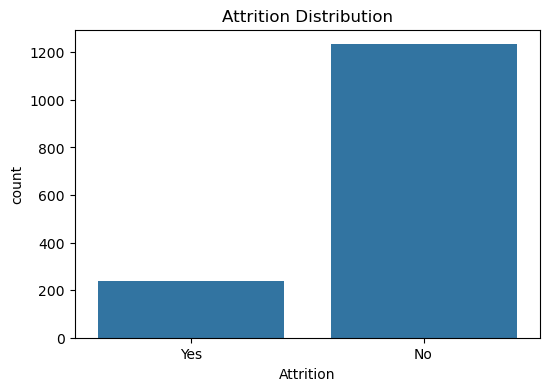

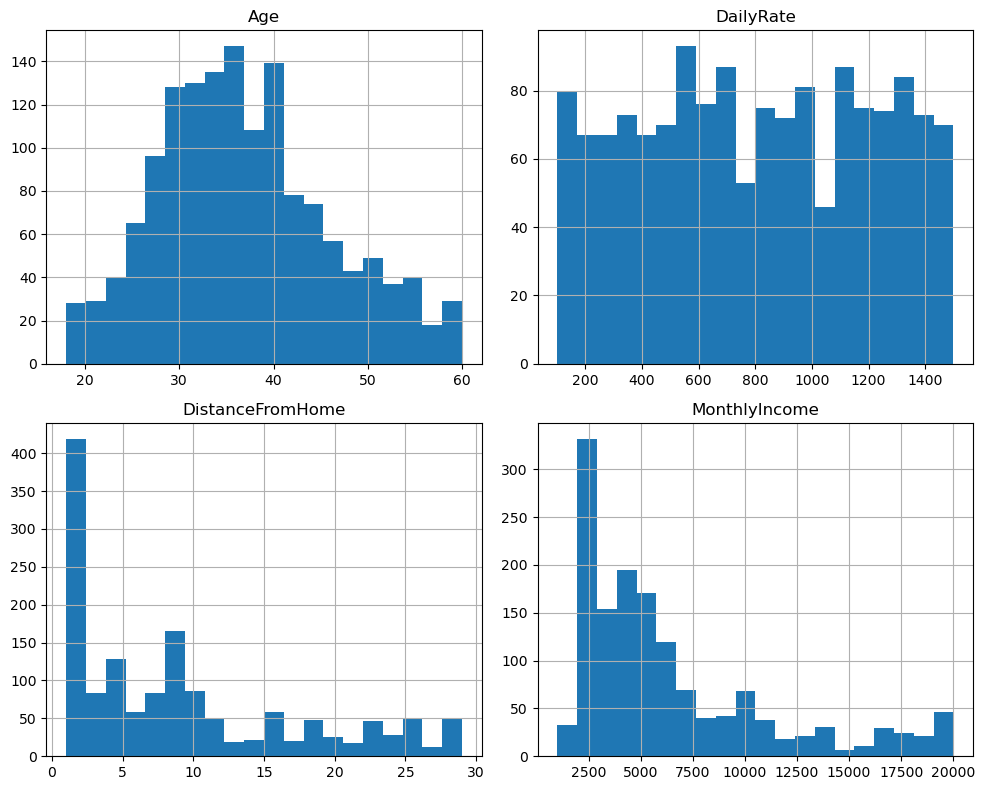

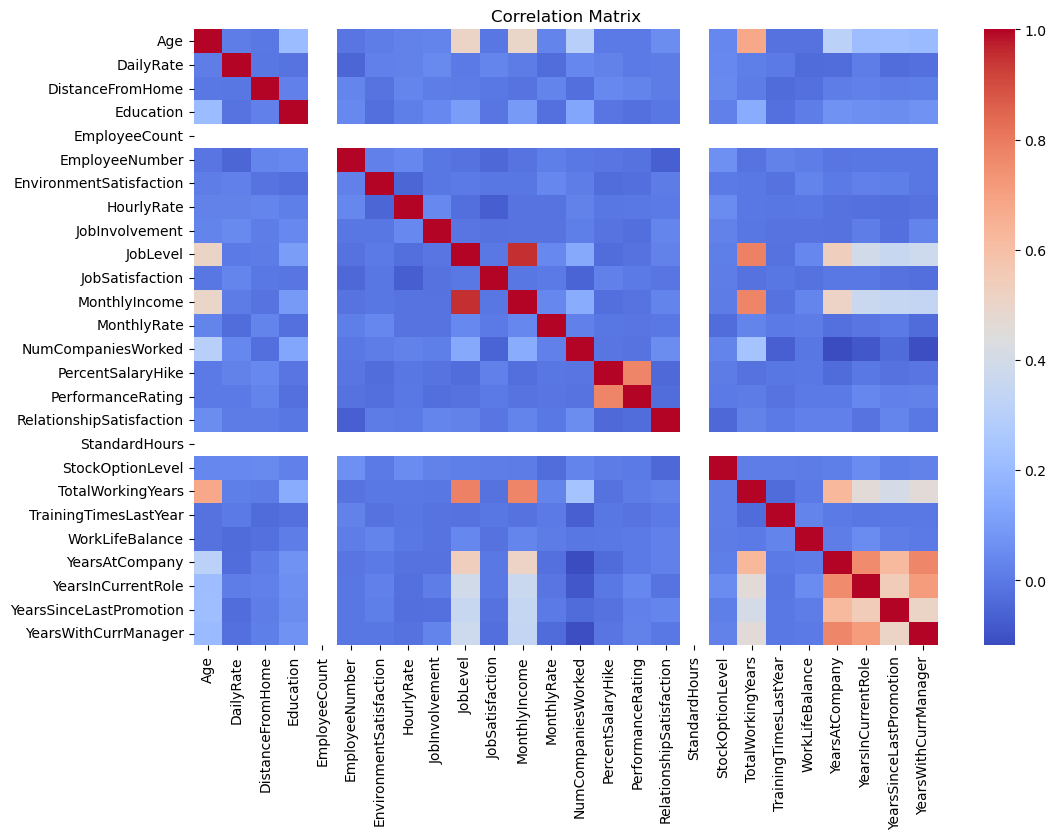

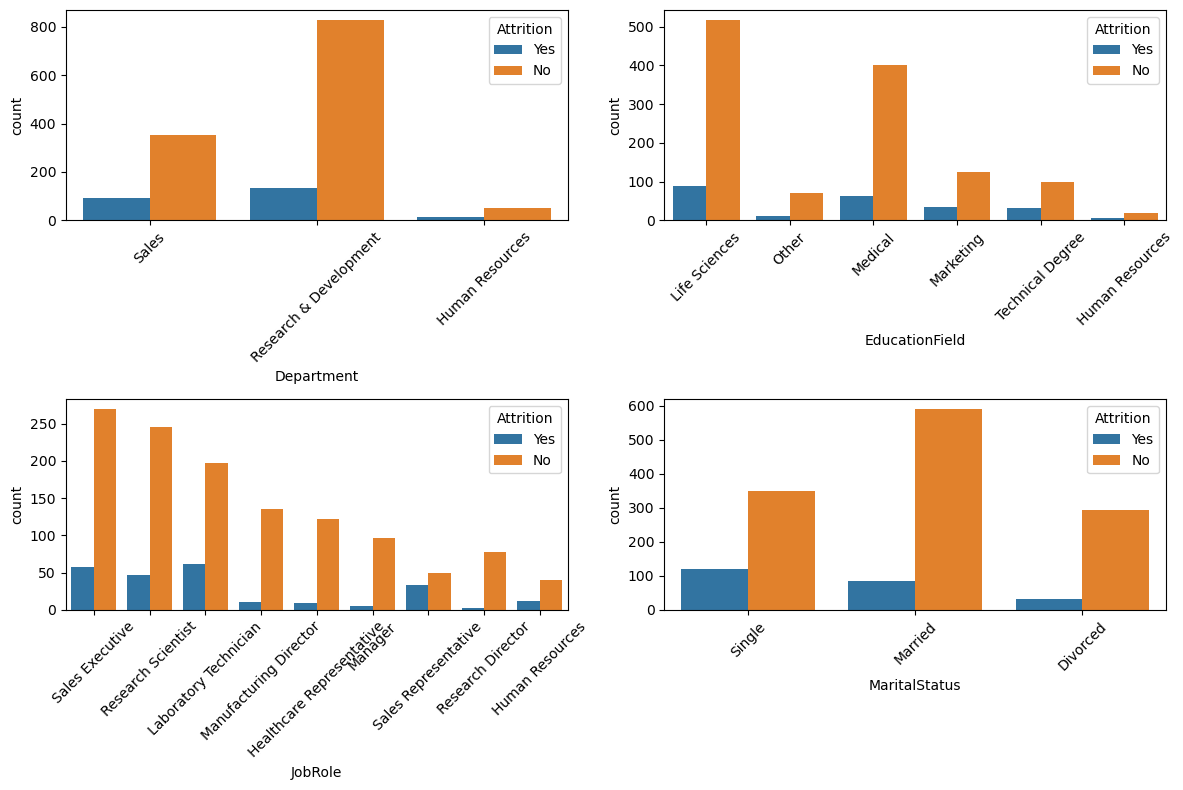

In [2]:
# ------------------
# EDA Section
# ------------------
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:")
print(df.head())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Target variable distribution
plt.figure(figsize=(6,4))
sns.countplot(x='Attrition', data=df)
plt.title('Attrition Distribution')
plt.show()

# Numerical features distribution
num_cols = ['Age', 'DailyRate', 'DistanceFromHome', 'MonthlyIncome']
df[num_cols].hist(figsize=(10,8), bins=20)
plt.tight_layout()
plt.show()

# Correlation matrix
plt.figure(figsize=(12,8))
corr_matrix = df.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Categorical features analysis
cat_cols = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']
plt.figure(figsize=(12,8))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2,2,i)
    sns.countplot(x=col, hue='Attrition', data=df)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Model Performance:
Accuracy: 0.8707482993197279
ROC AUC: 0.7317244846656611

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93       255
           1       0.60      0.08      0.14        39

    accuracy                           0.87       294
   macro avg       0.74      0.53      0.53       294
weighted avg       0.84      0.87      0.82       294



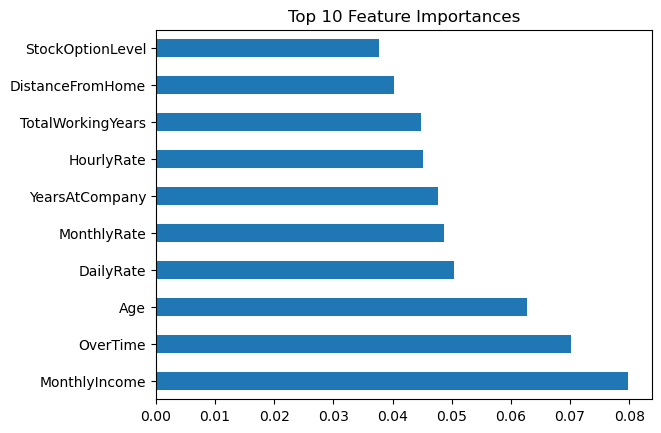

In [4]:
# ------------------
# Model Training
# ------------------
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print("\nModel Performance:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importance
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Feature Importances')
plt.show()